In [1]:
import os
import sys
# Add the src directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
from src.data_handling.historical_data_handler import SingleSymbolDataHandler
from src.feature_engineering.feature_extractor import SingleSymbolFeatureExtractor
%cd $project_root

/Users/zhaoyub/Documents/Tradings/tradebotv3


/Users/zhaoyub/Library/Python/3.12/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%load_ext autoreload

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
datahandler = SingleSymbolDataHandler('BTCUSDT')
inter, begin, end = '15m', '2023-01-01', '2024-09-24'
datahandler.load_data(inter, begin, end)
BTC_indicator = SingleSymbolFeatureExtractor('BTCUSDT', datahandler)
BTC_indicator.load_full_range()
indicators = BTC_indicator.indicators[['rsi', 'macd', 'stoch_k', 'bollinger_upper', 'atr', 'obv', 'vwap', 'adx','sma']]
indicators = pd.concat([indicators,datahandler.cleaned_data[['close', 'volume']]],axis= 1)

In [7]:
BTC_indicator.indicators.columns

Index(['rsi', 'macd', 'macd_signal', 'macd_diff', 'stoch_k', 'stoch_d',
       'bollinger_mavg', 'bollinger_upper', 'bollinger_lower', 'atr', 'vwap',
       'obv', 'sma', 'ema', 'adx'],
      dtype='object')

## What indicates a larger RSI variance?

In [8]:
window_roll_var = 15
window_RSI = 15
window_price = 15 
indicators['rsi_var'] = indicators['rsi'].rolling(window_roll_var).std().shift(1).bfill().ffill()
# indicators['rsi_var_past'] = indicators['rsi'].rolling(window_roll_var).std().bfill().ffill()
indicators['price_var'] = indicators['close'].rolling(window_price).std().bfill().ffill()
indicators['return'] = indicators['close'].pct_change().shift(-1).bfill().ffill()
# indicators['return_var'] = indicators['return'].rolling(10).std().bfill().ffill()
# indicators['rsi_var_2'] = indicators['rsi'].rolling(window_roll_var).std().shift(-0).bfill().ffill()
# indicators['rsi_min'] = indicators['rsi'].rolling(window_RSI).min().shift(1).bfill().ffill()
# indicators['rsi_min_past'] = indicators['rsi'].rolling(window_RSI).min().bfill().ffill()

# indicators['rsi_max'] = indicators['rsi'].rolling(window_RSI).max().shift(1).bfill().ffill()
# indicators['rsi_max_past'] = indicators['rsi'].rolling(window_RSI).max().bfill().ffill()

In [9]:
# indicators['rsi_max'].plot()
# indicators['rsi_min'].plot()
# plt.ylabel('RSI')
# plt.legend()

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
indicators_scaled = pd.DataFrame(scaler.fit_transform(indicators), columns=indicators.columns)

In [14]:
correlation_matrix = indicators_scaled.corr()
# correlation_matrix['rsi_max'].sort_values(ascending=False).head(8).index

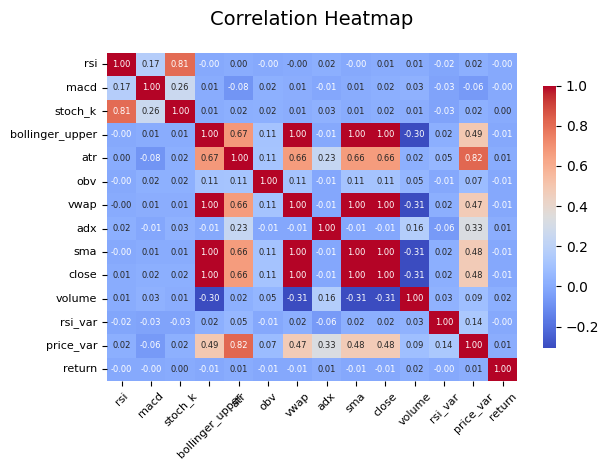

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={"shrink": 0.8, "aspect": 20}, annot_kws={"size": 6})
plt.title("Correlation Heatmap", fontsize=14, pad=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()